In [152]:
import copy
import sklearn
import numpy as np
from tensorflow import keras
from pgmpy.utils import get_example_model
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from explainer.metrics import draw_network, markov_blanket, distribution_drift, average_distribution_drift, fidelity_plot

#### Data

  0%|          | 0/37 [00:00<?, ?it/s]

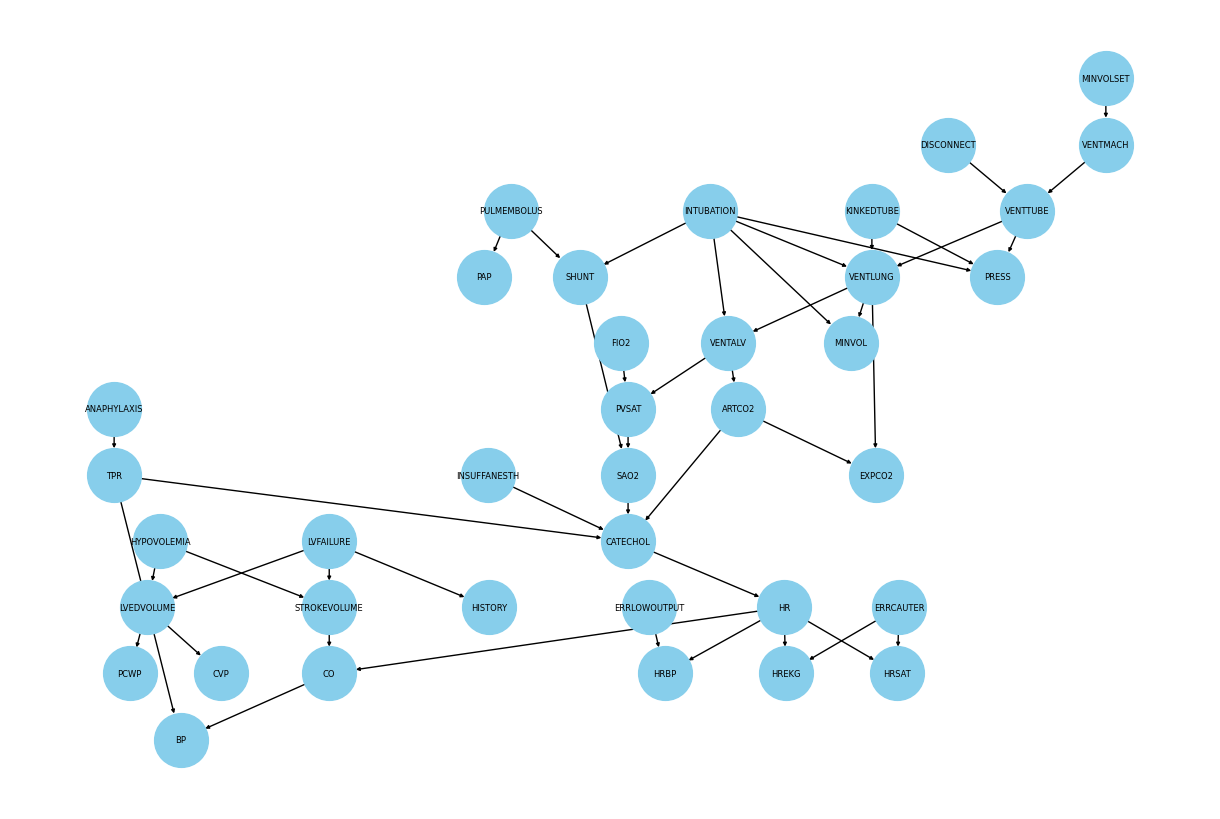

In [480]:
ground_bn = get_example_model("alarm")

dataset = ground_bn.simulate(n_samples = 1000)

draw_network(ground_bn)


In [481]:
dataset.columns

Index(['HR', 'HRBP', 'INSUFFANESTH', 'VENTTUBE', 'FIO2', 'ANAPHYLAXIS',
       'HYPOVOLEMIA', 'INTUBATION', 'DISCONNECT', 'HISTORY', 'LVEDVOLUME',
       'CVP', 'ARTCO2', 'SHUNT', 'VENTMACH', 'TPR', 'BP', 'PVSAT', 'PRESS',
       'HREKG', 'PULMEMBOLUS', 'PCWP', 'MINVOL', 'SAO2', 'LVFAILURE',
       'ERRCAUTER', 'STROKEVOLUME', 'KINKEDTUBE', 'PAP', 'MINVOLSET',
       'ERRLOWOUTPUT', 'VENTALV', 'CO', 'CATECHOL', 'HRSAT', 'EXPCO2',
       'VENTLUNG'],
      dtype='object')

In [989]:
target_name = 'HRSAT'
feature_names = list(dataset.drop(target_name, axis = 1).columns)

X = dataset.drop(target_name, axis = 1).to_numpy()
y = dataset[target_name].to_numpy()

In [990]:
dataset[target_name]

0      HIGH
1      HIGH
2      HIGH
3      HIGH
4      HIGH
       ... 
995    HIGH
996     LOW
997    HIGH
998    HIGH
999    HIGH
Name: HRSAT, Length: 1000, dtype: category
Categories (3, object): ['HIGH', 'LOW', 'NORMAL']

In [992]:
dataset[dataset[target_name] == 'HIGH']

HR    HRBP INSUFFANESTH VENTTUBE    FIO2 ANAPHYLAXIS HYPOVOLEMIA  \
0    HIGH  NORMAL        FALSE     ZERO  NORMAL       FALSE        TRUE   
1    HIGH    HIGH        FALSE      LOW  NORMAL       FALSE       FALSE   
2    HIGH    HIGH        FALSE     ZERO  NORMAL       FALSE       FALSE   
3    HIGH  NORMAL        FALSE     HIGH  NORMAL       FALSE       FALSE   
4    HIGH  NORMAL        FALSE     ZERO  NORMAL       FALSE       FALSE   
..    ...     ...          ...      ...     ...         ...         ...   
994  HIGH    HIGH        FALSE      LOW  NORMAL       FALSE       FALSE   
995  HIGH  NORMAL        FALSE      LOW  NORMAL       FALSE       FALSE   
997  HIGH    HIGH        FALSE      LOW  NORMAL       FALSE       FALSE   
998  HIGH    HIGH        FALSE      LOW  NORMAL       FALSE       FALSE   
999  HIGH    HIGH        FALSE      LOW  NORMAL       FALSE       FALSE   

    INTUBATION DISCONNECT HISTORY  ... KINKEDTUBE     PAP MINVOLSET  \
0       NORMAL      FALSE   FALSE  ...      FALSE  NORMAL       LOW   
1       NORMAL      FALSE   FALSE  ...      FALSE  NORMAL    NORMAL   
2       NORMAL      FALSE   FALSE  ...      FALSE  NORMAL    NORMAL   
3       NORMAL      FALSE   FALSE  ...      FALSE    HIGH      HIGH   
4       NORMAL       TRUE   FALSE  ...      FALSE  NORMAL    NORMAL   
..         ...        ...     ...  ...        ...     ...       ...   
994     NORMAL      FALSE   FALSE  ...      FALSE    HIGH    NORMAL   
995     NORMAL      FALSE   FALSE  ...      FALSE  NORMAL    NORMAL   
997     NORMAL      FALSE   FALSE  ...       TRUE  NORMAL    NORMAL   
998     NORMAL      FALSE   FALSE  ...      FALSE  NORMAL    NORMAL   
999     NORMAL      FALSE   FALSE  ...      FALSE  NORMAL    NORMAL   

    ERRLOWOUTPUT VENTALV      CO CATECHOL HRSAT  EXPCO2 VENTLUNG  
0           TRUE    HIGH    HIGH     HIGH  HIGH     LOW      LOW  
1          FALSE    ZERO  NORMAL     HIGH  HIGH     LOW     ZERO  
2          FALSE    HIGH    HIGH     HIGH  HIGH     LOW      LOW  
3           TRUE    HIGH    HIGH     HIGH  HIGH     LOW      LOW  
4           TRUE    ZERO    HIGH     HIGH  HIGH  NORMAL      LOW  
..           ...     ...     ...      ...   ...     ...      ...  
994        FALSE    ZERO    HIGH     HIGH  HIGH     LOW     ZERO  
995         TRUE    ZERO    HIGH     HIGH  HIGH     LOW     ZERO  
997        FALSE    ZERO    HIGH     HIGH  HIGH     LOW     ZERO  
998        FALSE     LOW    HIGH     HIGH  HIGH    HIGH     HIGH  
999        FALSE    ZERO    HIGH     HIGH  HIGH     LOW     ZERO  

[704 rows x 37 columns]

In [993]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y.squeeze())

X = feature_encoder.transform(X)
y = target_encoder.transform(y)

In [994]:
X_train, X_test, y_train, y_test = train_test_split(X, y.squeeze(), test_size = 0.2, random_state = 42)

#### Model

In [995]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [996]:
n_classes = len(np.unique(y_train))
input_shape = len(X_train[0])
n_layers = 3
n_nodes_l = 5
n_nodes_u = 25
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [997]:
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2)
model.summary()

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5656 - loss: 0.9417 - val_accuracy: 0.7188 - val_loss: 0.8216
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7078 - loss: 0.8077 - val_accuracy: 0.7188 - val_loss: 0.7823
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7078 - loss: 0.7524 - val_accuracy: 0.7188 - val_loss: 0.7186
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7078 - loss: 0.6584 - val_accuracy: 0.7188 - val_loss: 0.5620
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8031 - loss: 0.4845 - val_accuracy: 0.8750 - val_loss: 0.3581
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8891 - loss: 0.3217 - val_accuracy: 0.8750 - val_loss: 0.2550
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9109 - loss: 0.2682 - val_accuracy: 0.9187 - val_loss: 0.2219
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9406 - loss: 0.2472 - val_accuracy: 0.9563 - val_loss

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_186 (Dense)               │ (None, 5)              │           185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 14)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 21)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 3)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,952 (7.63 KB)

 Trainable params: 650 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,302 (5.09 KB)

In [998]:
y_pred = model(X_test)
y_pred = np.argmax(y_pred, axis = 1)

accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9200


#### Explanations

In [999]:
import numpy as np
import pandas as pd
from pgmpy.base import PDAG
from pgmpy.estimators import PC, HillClimbSearch, ExpertKnowledge, GES
from explainer.metrics import distribution_drift, average_distribution_drift

In [1000]:
class Explainer:
    
    def __init__(self, model, training_data, feature_names, target_name, n_samples = 100, rep_prob = 0.5):

        self.model = model
        self.training_data = training_data
        self.feature_names = feature_names
        self.target_name = target_name
        self.n_samples = n_samples
        self.rep_prob = rep_prob

        self.local_data = None
        
        self.pc_blanket = None
        self.pc_dag = None
        
        self.bic_blanket = None
        self.bic_dag = None
        
    def data_generation(self, instance):
        
        instance_prediction = np.argmax(self.model.predict(instance.reshape(1, -1)).squeeze(0))
        
        random_indices = np.random.randint(len(self.training_data), size = self.n_samples)
        random_datapoints = self.training_data[random_indices]
        
        replacement_mask = np.random.rand(self.n_samples, random_datapoints.shape[1]) < self.rep_prob

        samples = np.where(replacement_mask, instance, random_datapoints)
                
        sample_predictions = np.argmax(self.model.predict(samples), axis = 1)
                
        sample_prediction_masks = sample_predictions != instance_prediction
        
        sample_masks = samples != instance
        
        masked_samples = sample_masks.astype(str)
        masked_sample_predictions = sample_prediction_masks.astype(str)
        
        self.local_data = pd.DataFrame(masked_samples, columns = self.feature_names)
        self.local_data[self.target_name] = masked_sample_predictions
    
    def get_structures(self):

        data = self.local_data
        
        pc_est = PC(data) # constraint-based
        bic_est = GES(data) # score-based
        
        pc_dag = pc_est.estimate(ci_test = "chi_square", return_type = "dag")
        bic_dag = bic_est.estimate(scoring_method = "bic-d")

        self.pc_dag = markov_blanket(pc_dag, self.target_name)
        self.bic_dag = markov_blanket(bic_dag, self.target_name)

        self.pc_blanket = self.pc_dag.get_markov_blanket(self.target_name)
        self.bic_blanket = self.bic_dag.get_markov_blanket(self.target_name)
        
    def log_data(self, instance):

        self.data_generation(instance)

In [1001]:
import plotly.express as px

In [1002]:
def in_distribution(instance, training_data, indices, radius = 0):
    
    diffs = np.sum(training_data[:, indices] != instance[indices], axis = 1)
    
    mask = diffs <= radius
    
    if not np.any(mask):

        return None

    candidates = np.unique(training_data[mask], axis = 0)
    
    return candidates

In [1009]:
def distribution_drift(instance, training_data, feature_set, feature_names, model, n_trials):

    og_distro = model(instance.reshape(1, -1)).numpy()[0]

    feature_indices = [feature_names.index(feature) for feature in feature_set]

    candidates = None
    
    radius = 0

    while True:

        candidates = in_distribution(instance, training_data, feature_indices, radius)

        if candidates is not None and candidates.shape[0] >= n_trials:

            break

        radius += 1

        if radius > len(feature_indices):

            raise RuntimeError(f"Not enough matching in distribution candidates even up to radius {radius}, reduce n_trials.")

    candidates = candidates[:n_trials].copy()

    candidates[:, feature_indices] = instance[feature_indices][None, :]

    new_distros = model(candidates).numpy()

    return new_distros, og_distro

In [1010]:
def average_distribution_drift(og_distro, new_distros, eps = 1e-12):

    og_distro = np.asarray(og_distro, dtype = np.float64)
    og_distro = (og_distro + eps) / (og_distro.sum() + eps * len(og_distro))

    js_values = []
    
    for new_d in new_distros:

        new_d = np.asarray(new_d, dtype = np.float64)
        new_d = (new_d + eps) / (new_d.sum() + eps * len(new_d))
        
        js_values.append(jensenshannon(og_distro, new_d) ** 2)

    avg_js = np.mean(js_values)

    return avg_js, js_values

In [1011]:
def divergence_plot(js_values, method_names):

    data = pd.DataFrame(js_values.T, columns = [f'{name}' for name in method_names])
    data_melt = data.melt(var_name = 'Method', value_name = 'Jensen-Shannon Divergence')
    
    fig = px.box(data_melt, x = 'Method', y = 'Jensen-Shannon Divergence', title = 'Jensen-Shannon Divergence per Method')
    
    fig.show()

In [1012]:
def fidelity_plot(new_distros, og_distro, title):
    
    fig = go.Figure()
    
    for distro in new_distros:
    
        fig.add_trace(go.Scatter(
            x = np.arange(new_distros.shape[1]),
            y = distro,
            mode = 'lines',
            line = dict(color = 'rgba(150, 150, 150, 0.5)'),
            showlegend = False
        ))
    
    fig.add_trace(go.Scatter(
        x = np.arange(new_distros.shape[1]),
        y = og_distro,
        mode = 'lines+markers',
        name = 'Original Distribution',
        line = dict(color = '#004aad', width = 3)
    ))
    
    fig.update_layout(
        title = f'{title} Class Distribution Drift',
        xaxis_title = 'Class Index',
        yaxis_title = 'Predicted Probability',
        template = 'simple_white'
    )

    fig.show()

In [ ]:
# 1. Add 2 datasets for fidelity checks
# 2. Add 2 BN datasets to evaluate structure recovery capability
# 3. Perform & record structure recovery capability
# 4. Add lime, shap, integrated hessians, and ground-mb to fidelity checks

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.06866342820848412
Explainer Features Fixed Jensen-Shannon: 0.00021659754833168947
Non-Explainer Features Fixed Jensen-Shannon: 0.16611771773742856


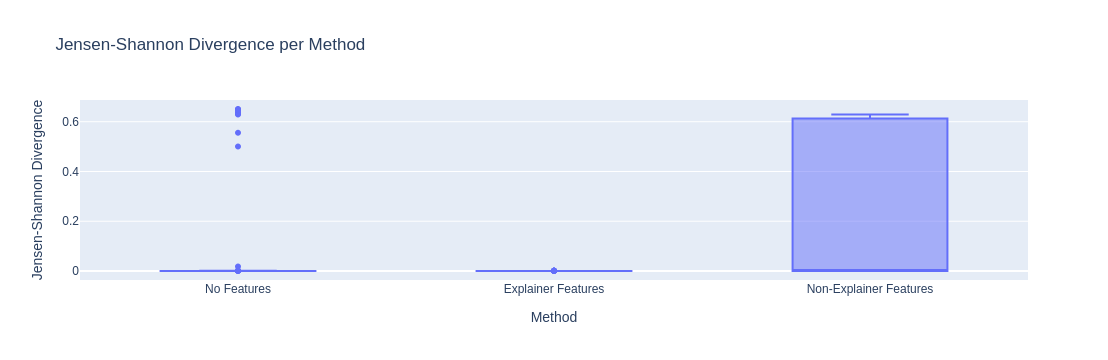

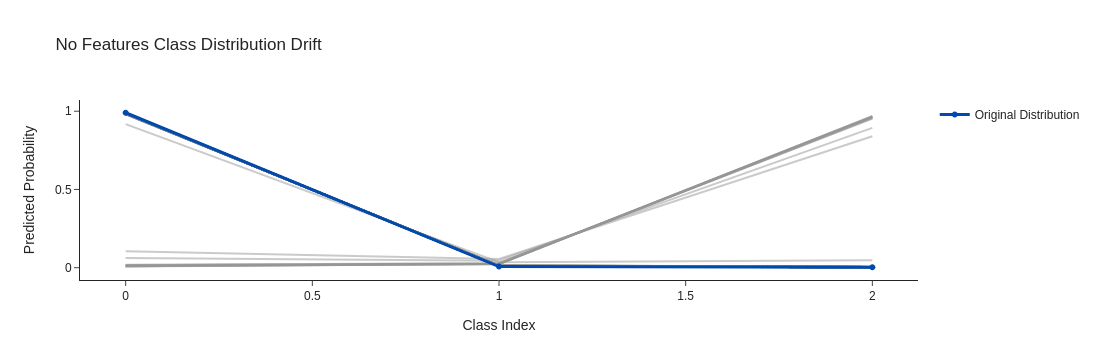

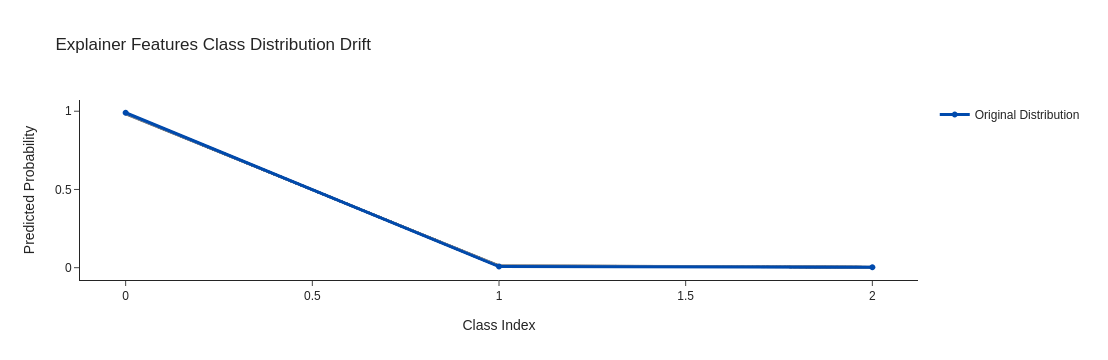

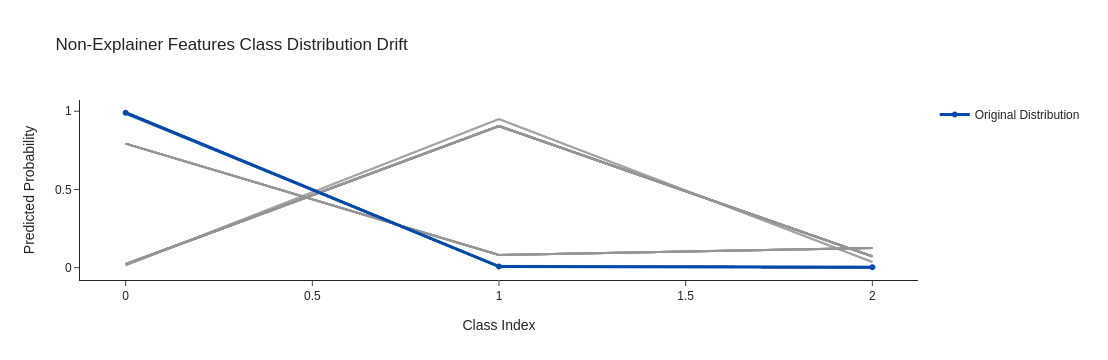

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.6150588257534113
Explainer Features Fixed Jensen-Shannon: 0.011461913407981566
Non-Explainer Features Fixed Jensen-Shannon: 0.40767707087669736


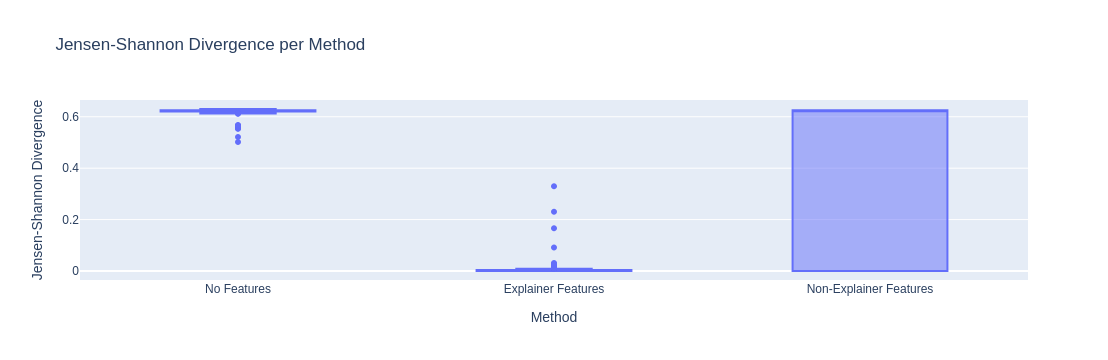

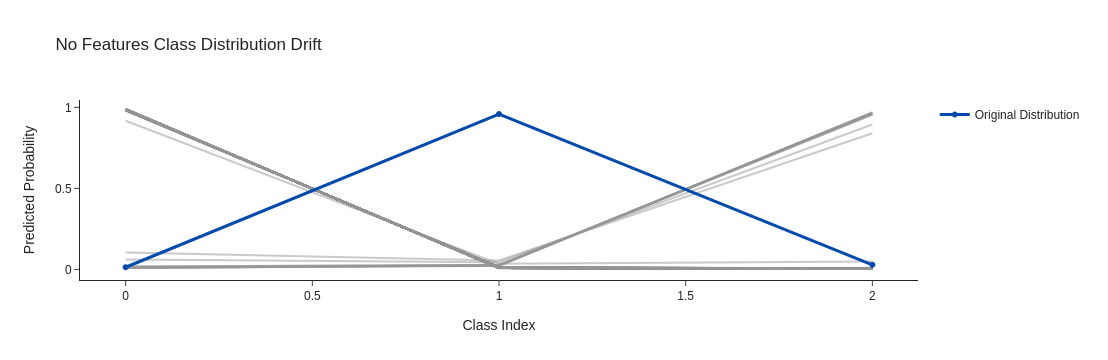

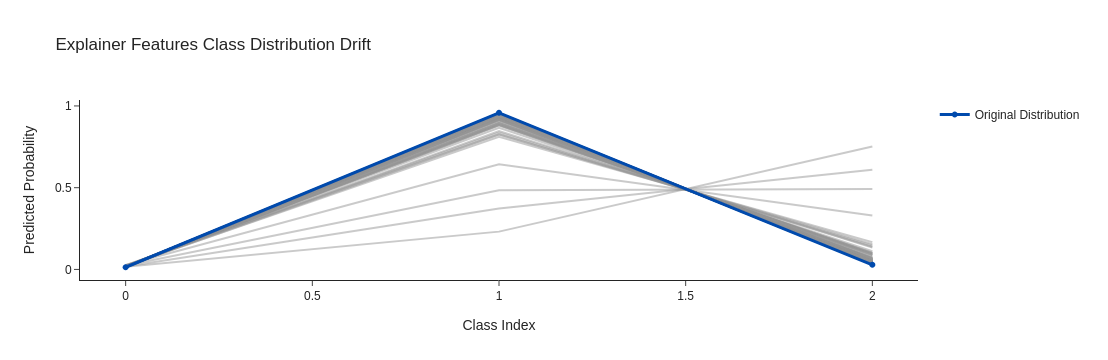

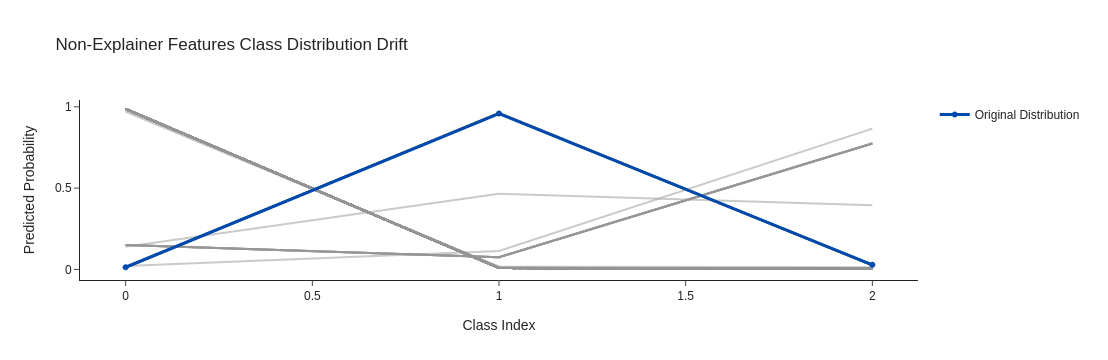

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.6003522461737549
Explainer Features Fixed Jensen-Shannon: 0.00869548830548576
Non-Explainer Features Fixed Jensen-Shannon: 0.5212624604713053


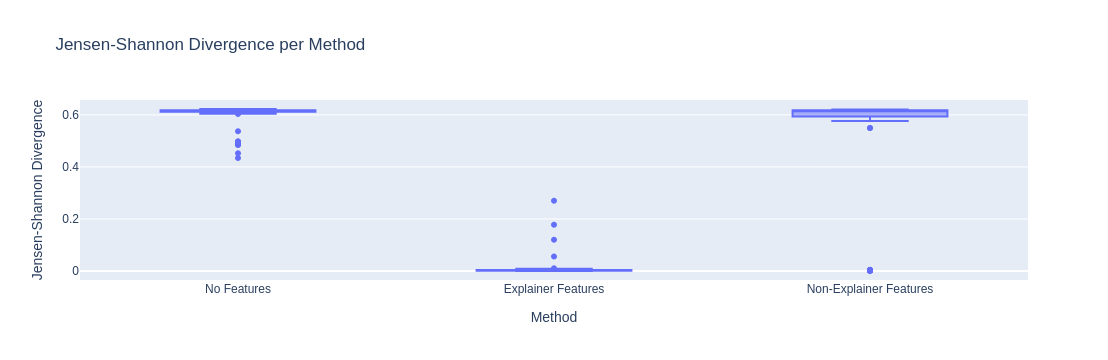

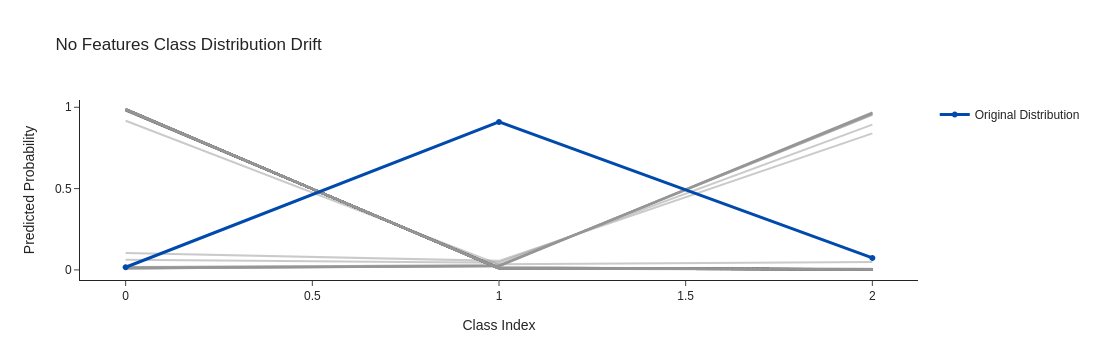

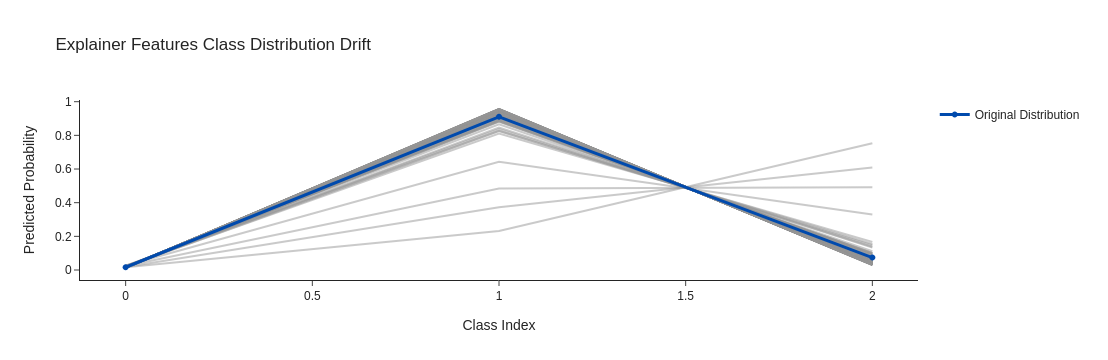

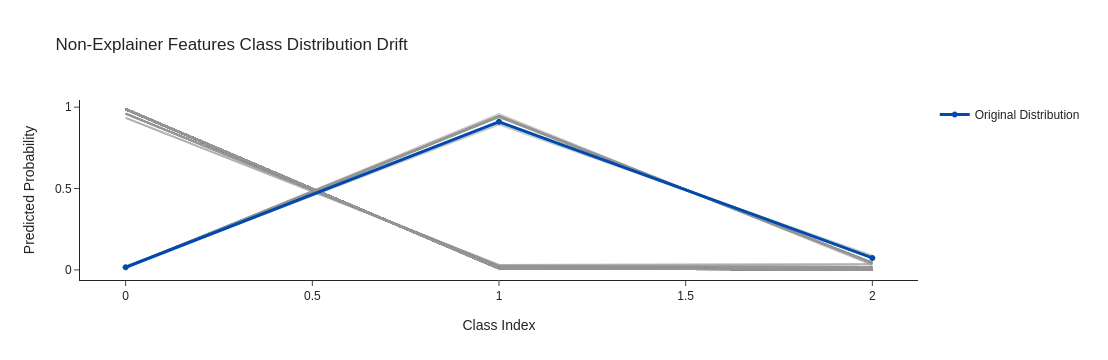

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.0680961605356889
Explainer Features Fixed Jensen-Shannon: 4.608379044818883e-05
Non-Explainer Features Fixed Jensen-Shannon: 0.00588563595910895


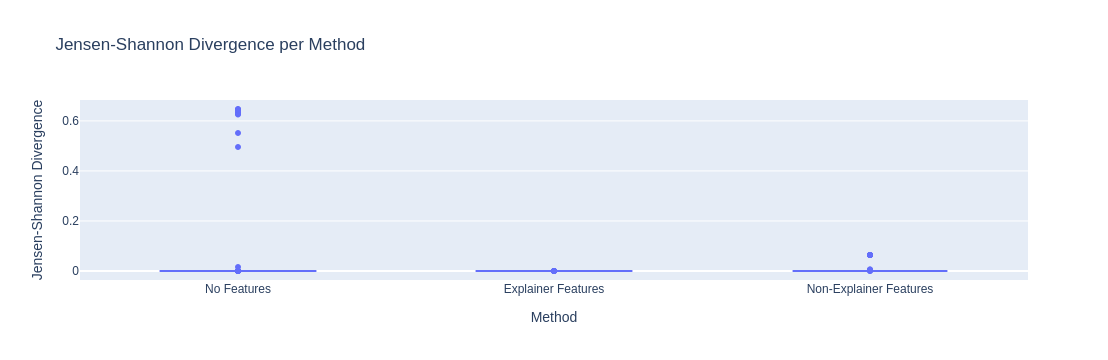

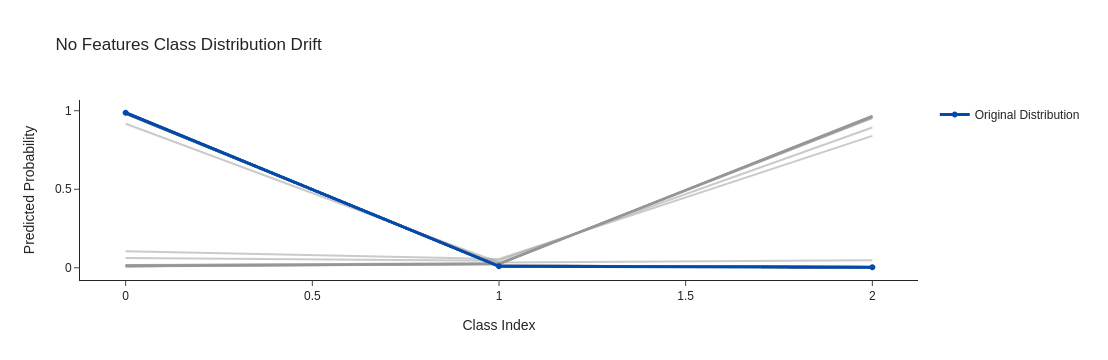

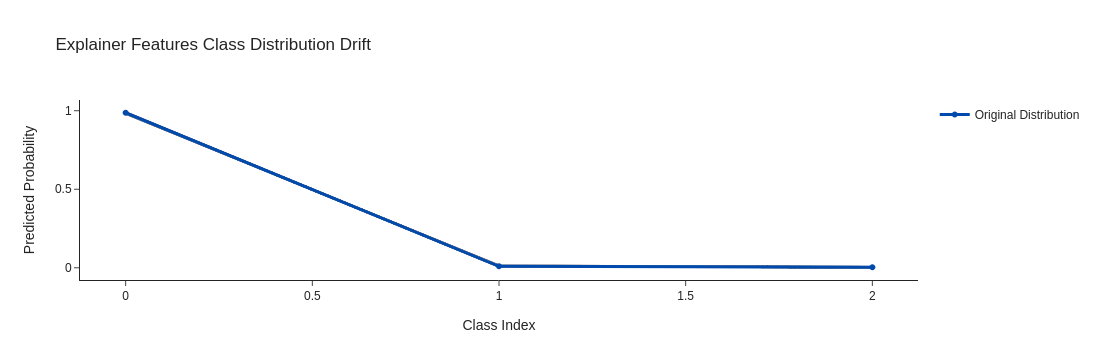

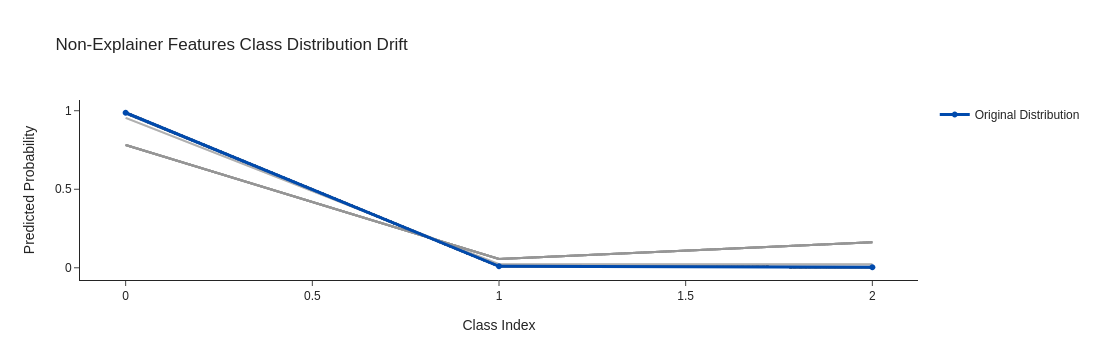

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.0680961605356889
Explainer Features Fixed Jensen-Shannon: 4.608379044818883e-05
Non-Explainer Features Fixed Jensen-Shannon: 0.10179737580689491


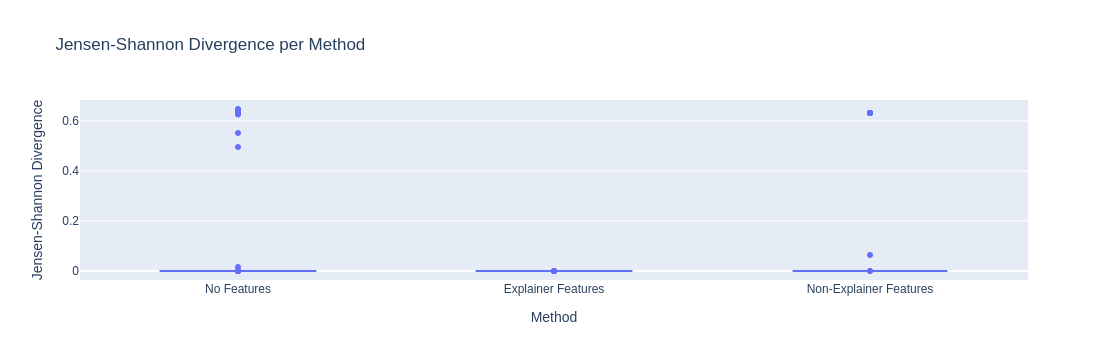

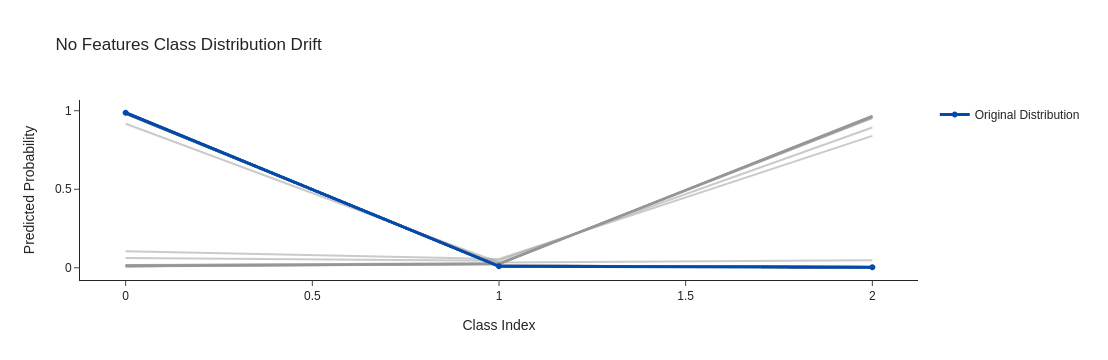

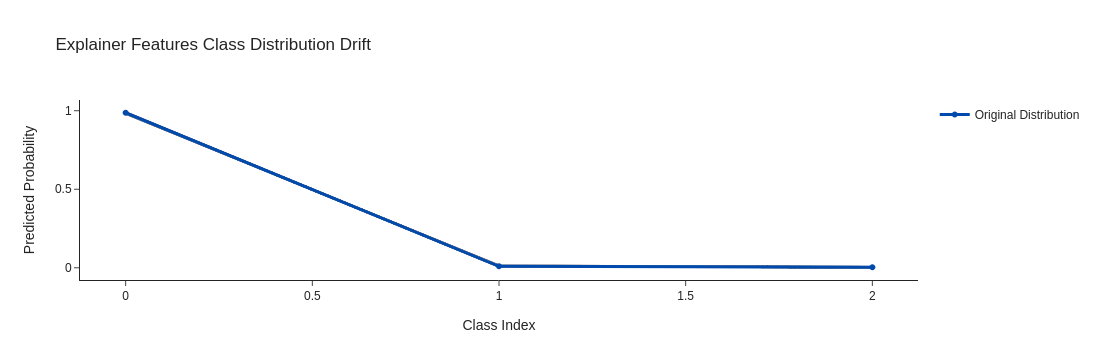

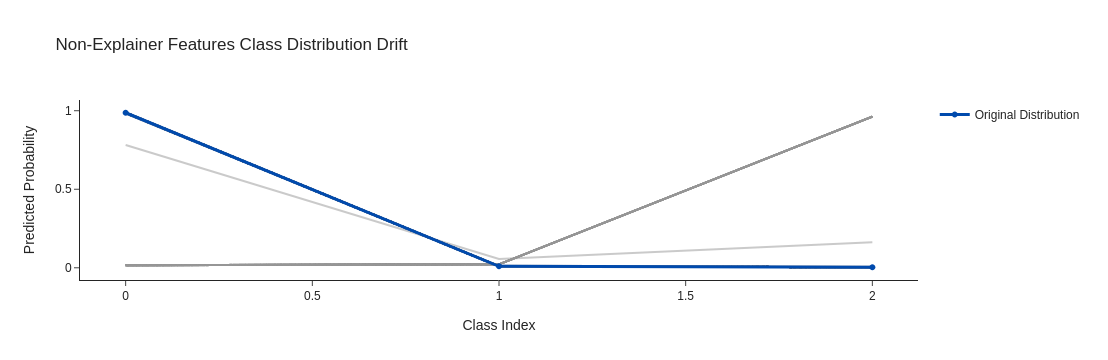

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.6003522461737549
Explainer Features Fixed Jensen-Shannon: 0.003626335407318657
Non-Explainer Features Fixed Jensen-Shannon: 0.5127732426548871


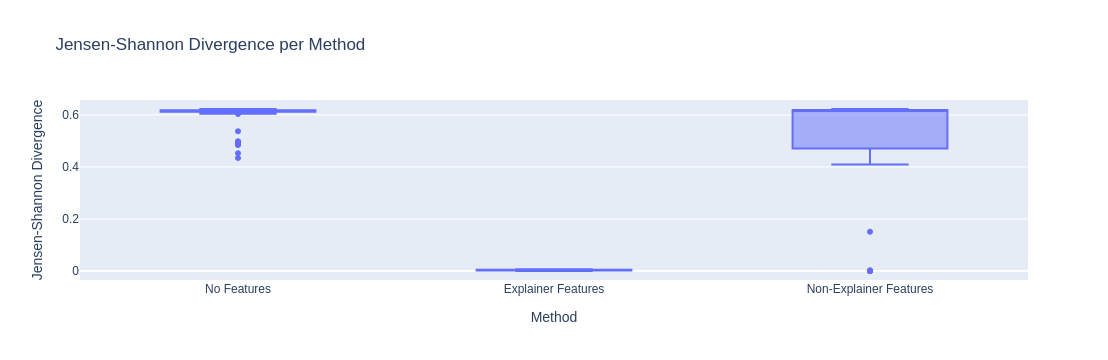

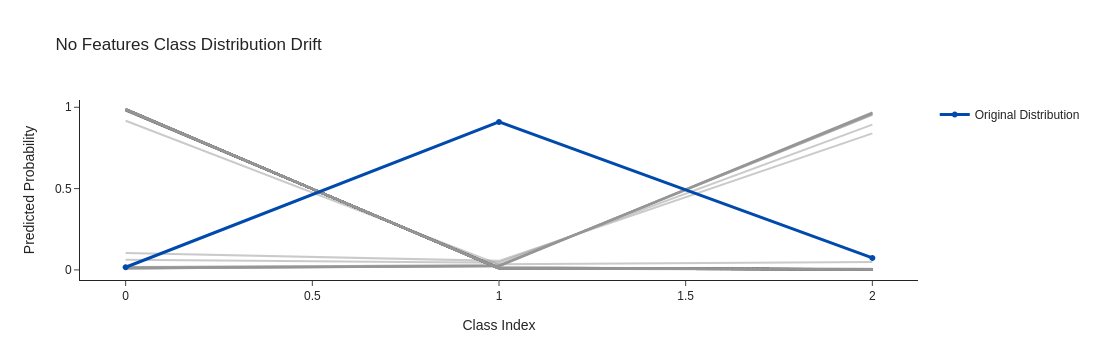

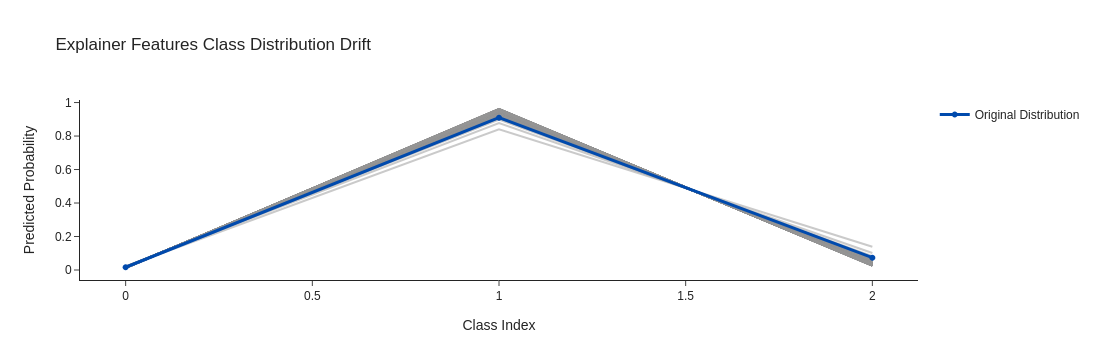

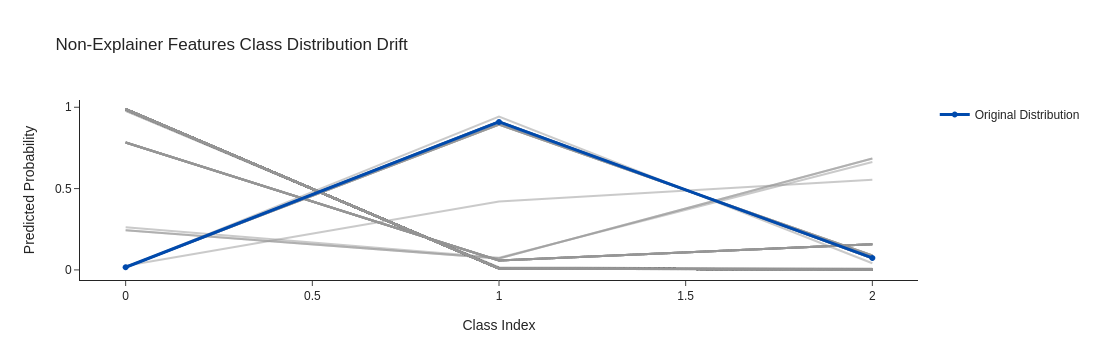

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.06826308236390727
Explainer Features Fixed Jensen-Shannon: 5.9449052973121006e-05
Non-Explainer Features Fixed Jensen-Shannon: 0.03715084733945576


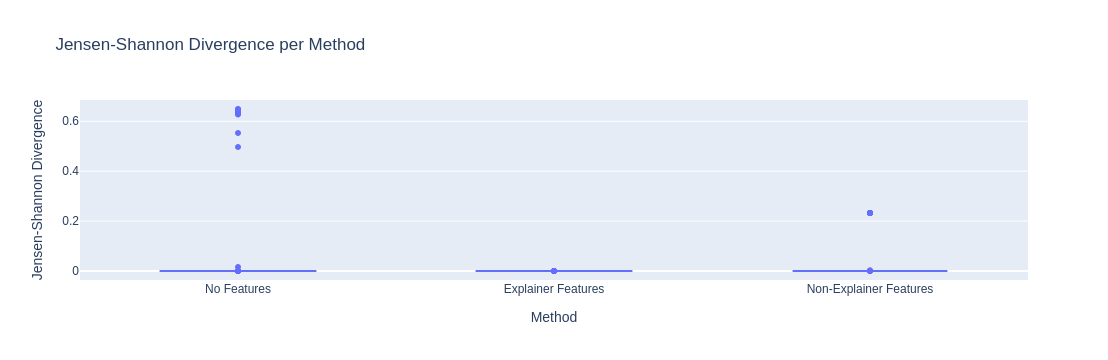

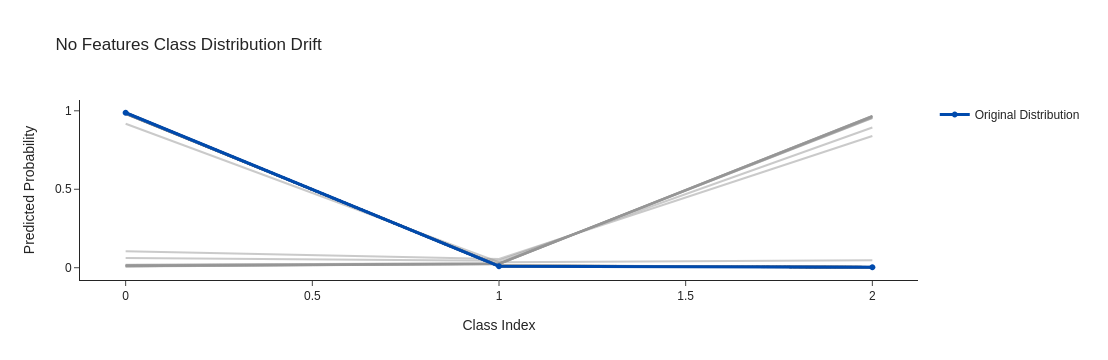

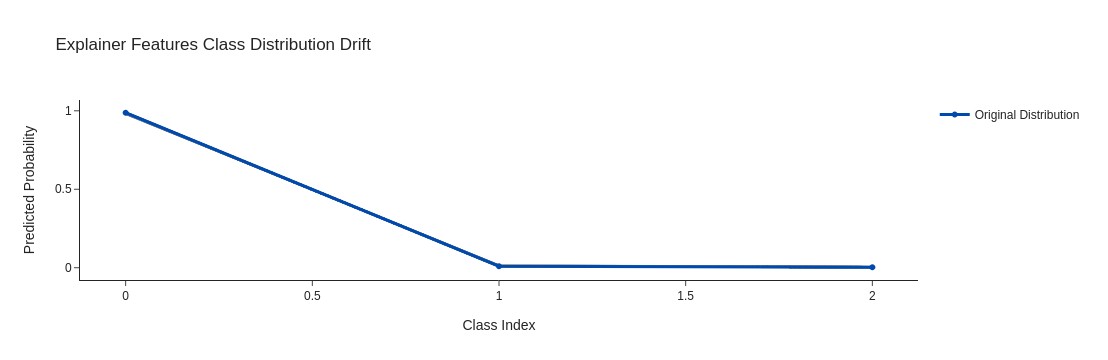

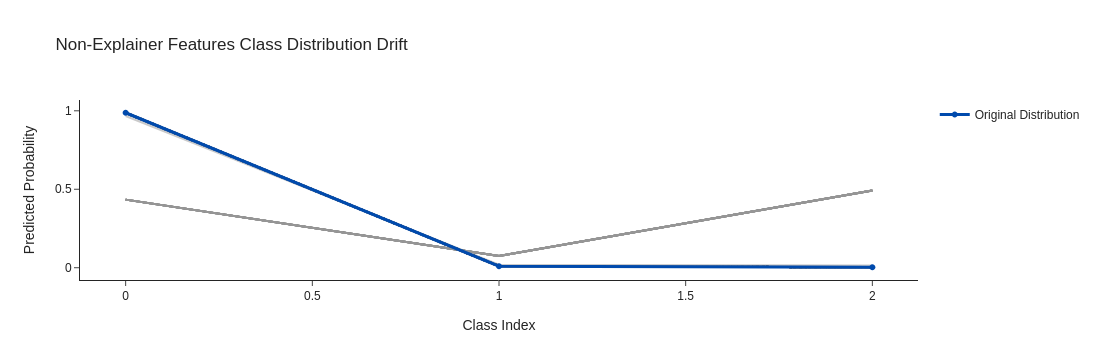

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.06848185274871656
Explainer Features Fixed Jensen-Shannon: 0.00015067149122376366
Non-Explainer Features Fixed Jensen-Shannon: 0.057344354245106685


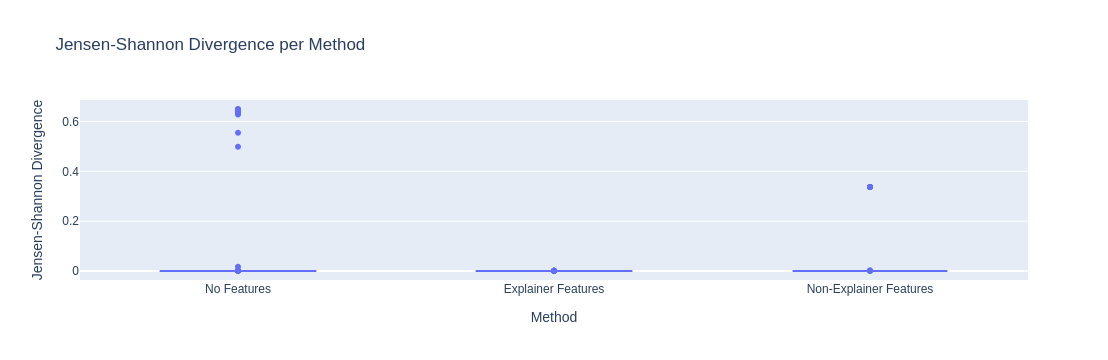

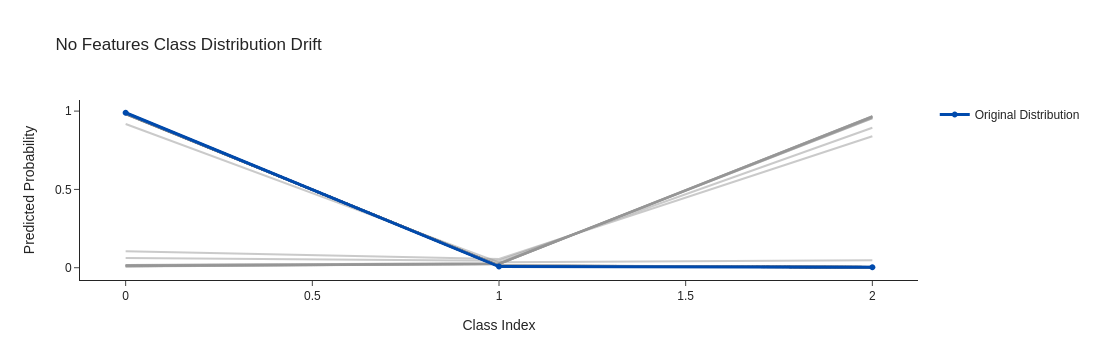

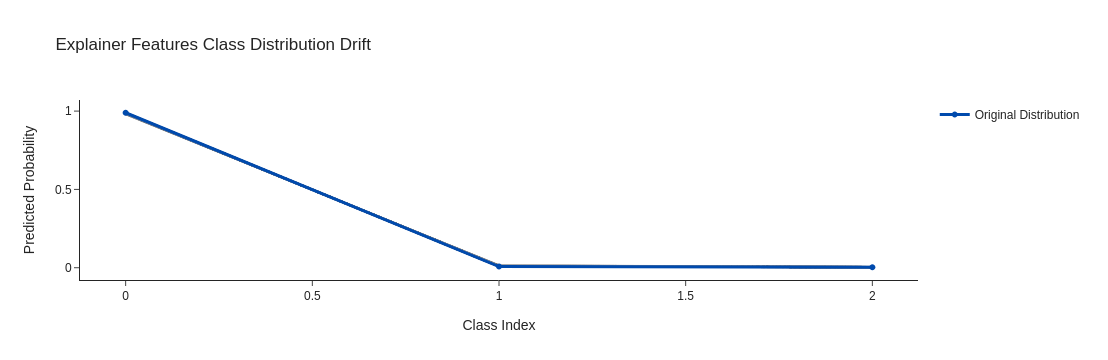

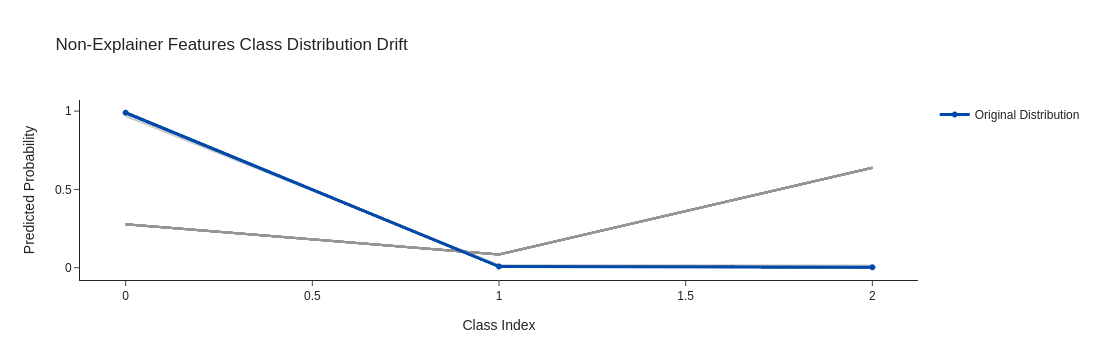

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.06785636712019641
Explainer Features Fixed Jensen-Shannon: 0.0001292267117429271
Non-Explainer Features Fixed Jensen-Shannon: 0.04281036051878875


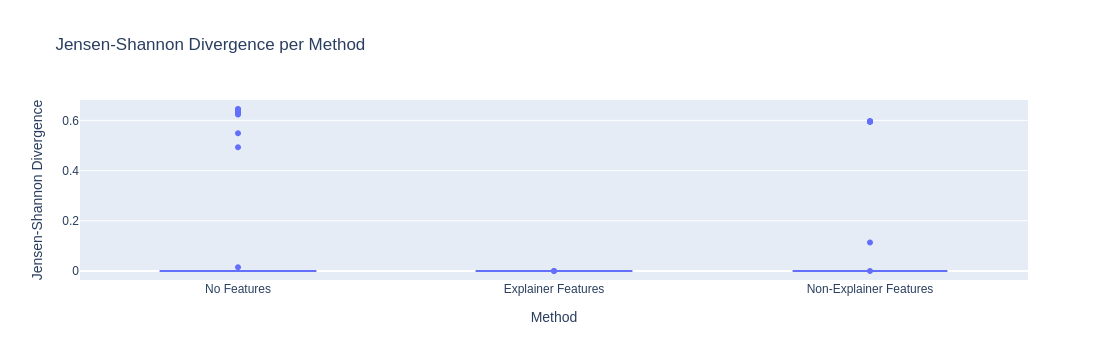

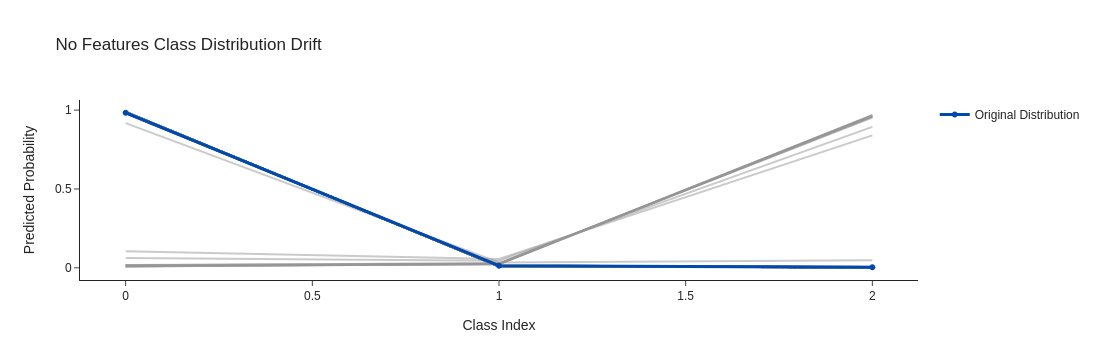

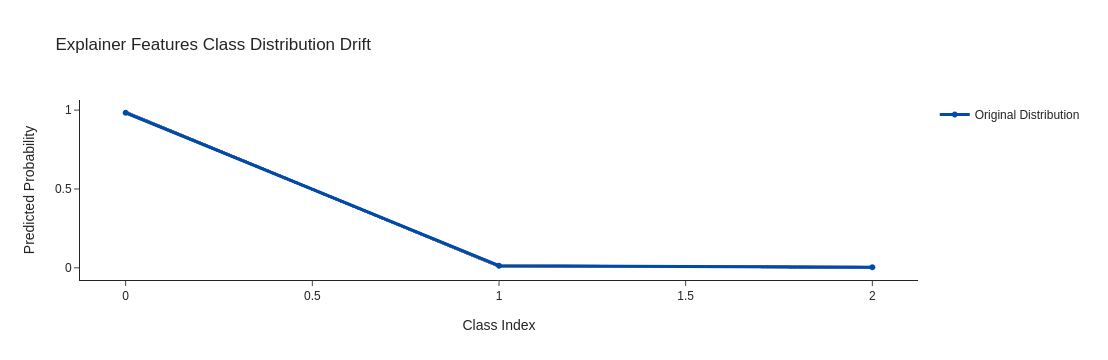

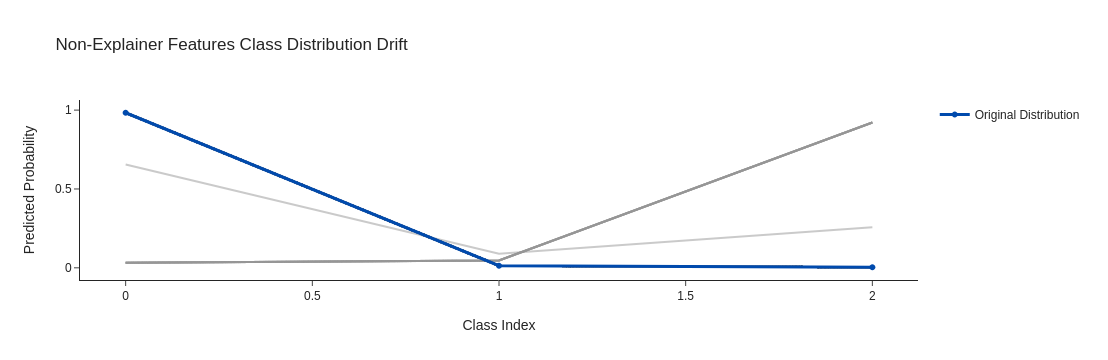

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C',

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBATION': 'C', 'DISCONNECT': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'CVP': 'C', 'ARTCO2': 'C', 'SHUNT': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'BP': 'C', 'PVSAT': 'C', 'PRESS': 'C', 'HREKG': 'C', 'PULMEMBOLUS': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'LVFAILURE': 'C', 'ERRCAUTER': 'C', 'STROKEVOLUME': 'C', 'KINKEDTUBE': 'C', 'PAP': 'C', 'MINVOLSET': 'C', 'ERRLOWOUTPUT': 'C', 'VENTALV': 'C', 'CO': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'VENTLUNG': 'C', 'HRSAT': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HR': 'C', 'HRBP': 'C', 'INSUFFANESTH': 'C', 'VENTTUBE': 'C', 'FIO2': 'C', 'ANAPHYLAXIS': 'C', 'HYPOVOLEMIA': 'C', 'INTUBAT

No Features Fixed Jensen-Shannon: 0.06806036632114408
Explainer Features Fixed Jensen-Shannon: 4.7260767786820224e-05
Non-Explainer Features Fixed Jensen-Shannon: 0.10353385660770258


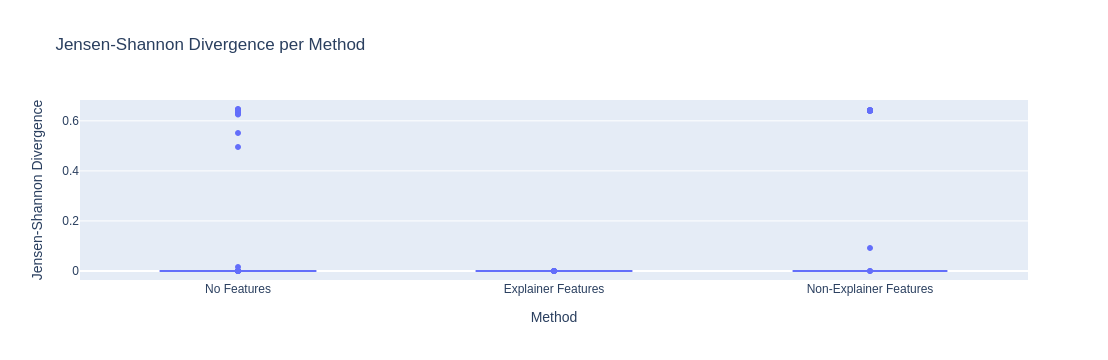

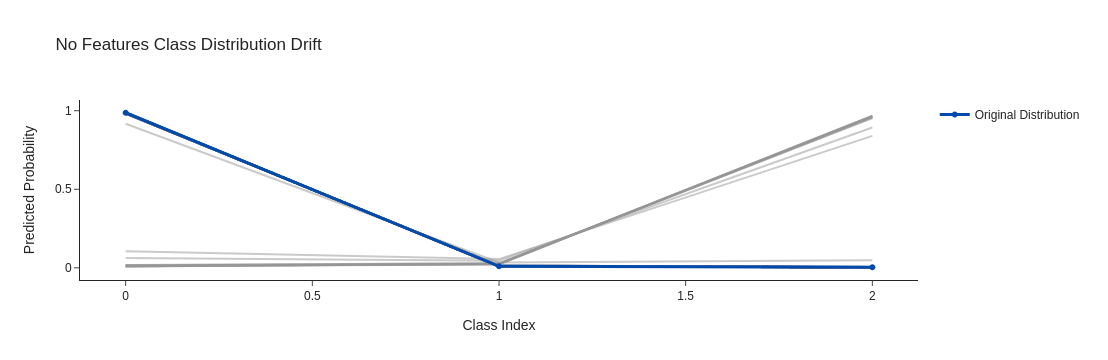

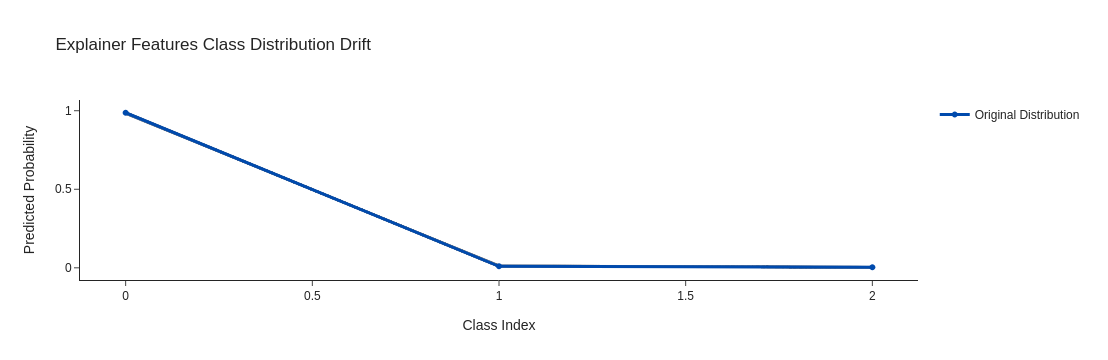

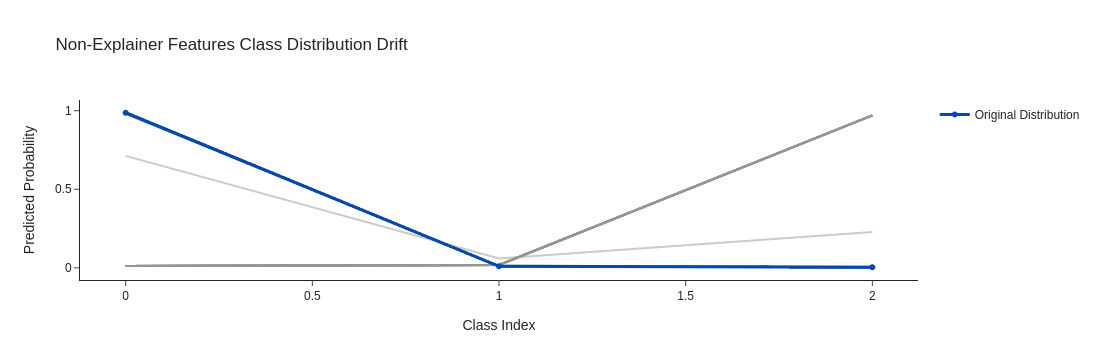

In [1014]:
for _ in range(10):
    
    explainer = Explainer(
        model = model, 
        training_data = X_train, 
        feature_names = feature_names, 
        target_name = target_name, 
        n_samples = 5000, 
        rep_prob = 0.1
    )
    
    instance = X_test[np.random.randint(X_test.shape[0])]
    
    explainer.log_data(instance)
    explainer.get_structures()
    
    no_features = []
    explainer_features = explainer.pc_blanket
    non_explainer_features = [f for f in feature_names if f not in explainer_features]
    
    no_new, no_og = distribution_drift(
        instance = instance, 
        training_data = X_train, 
        feature_set = no_features, 
        feature_names = feature_names, 
        model = model, 
        n_trials = 100
    )
    
    explainer_new, explainer_og = distribution_drift(
        instance = instance, 
        training_data = X_train, 
        feature_set = explainer_features, 
        feature_names = feature_names, 
        model = model, 
        n_trials = 100
    )
    
    non_e_new, non_e_og = distribution_drift(
        instance = instance, 
        training_data = X_train, 
        feature_set = non_explainer_features, 
        feature_names = feature_names, 
        model = model, 
        n_trials = 100
    )
    
    no_avg, no_values = average_distribution_drift(no_og, no_new)
    explainer_avg, explainer_values = average_distribution_drift(explainer_og, explainer_new)
    non_e_avg, non_e_values = average_distribution_drift(non_e_og, non_e_new)
    
    js_values = np.stack((no_values, explainer_values, non_e_values))
    method_names = ['No Features', 'Explainer Features', 'Non-Explainer Features']
    
    print(f'No Features Fixed Jensen-Shannon: {no_avg}')
    print(f'Explainer Features Fixed Jensen-Shannon: {explainer_avg}')
    print(f'Non-Explainer Features Fixed Jensen-Shannon: {non_e_avg}')
    
    divergence_plot(js_values, method_names)
    
    fidelity_plot(no_new, no_og, method_names[0])
    fidelity_plot(explainer_new, explainer_og, method_names[1])
    fidelity_plot(non_e_new, non_e_og, method_names[2])

In [1017]:
from explainer.metrics import metrics

Ground Markov Blanket: ['HR', 'ERRCAUTER'] 

Explainer Markov Blanket: ['HREKG', 'HR', 'ERRCAUTER'] 

Markov Blanket Accuracy: 2 / 3
Ground Markov Blanket: 



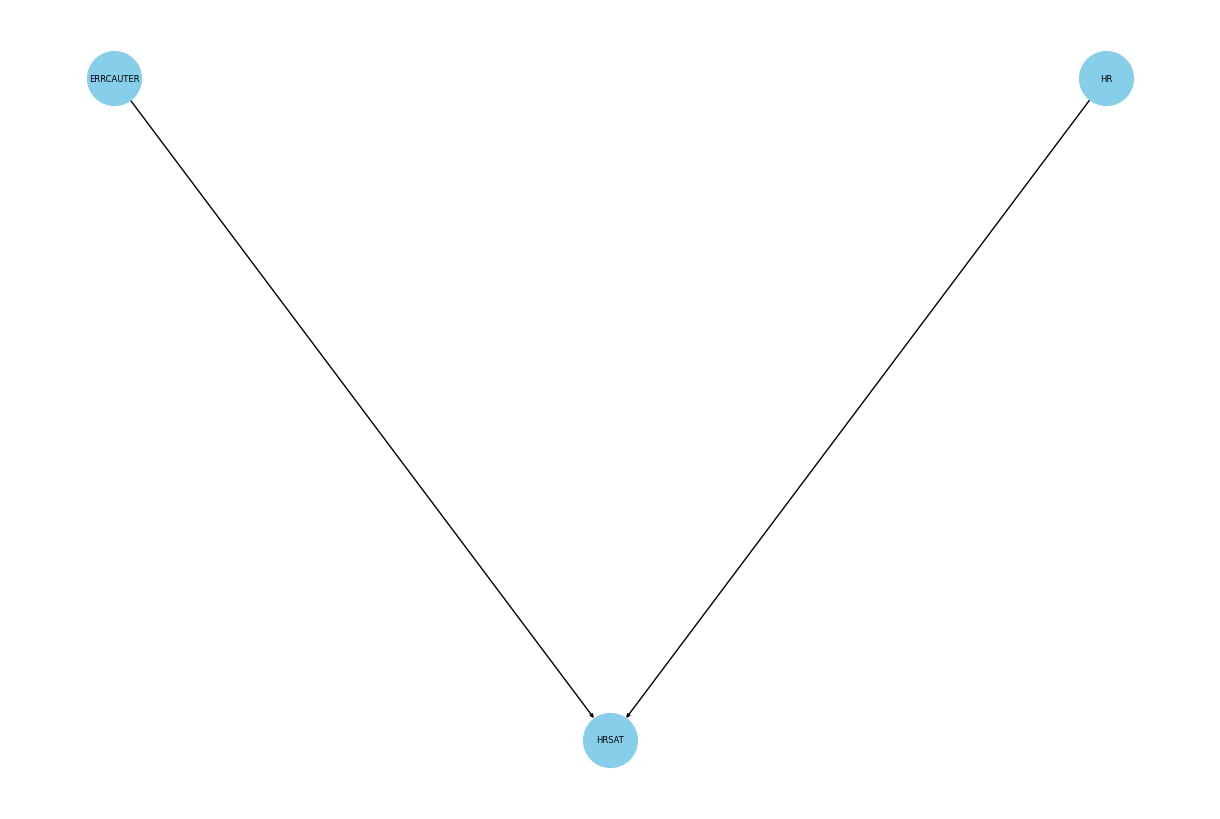

Explainer Markov Blanket: 



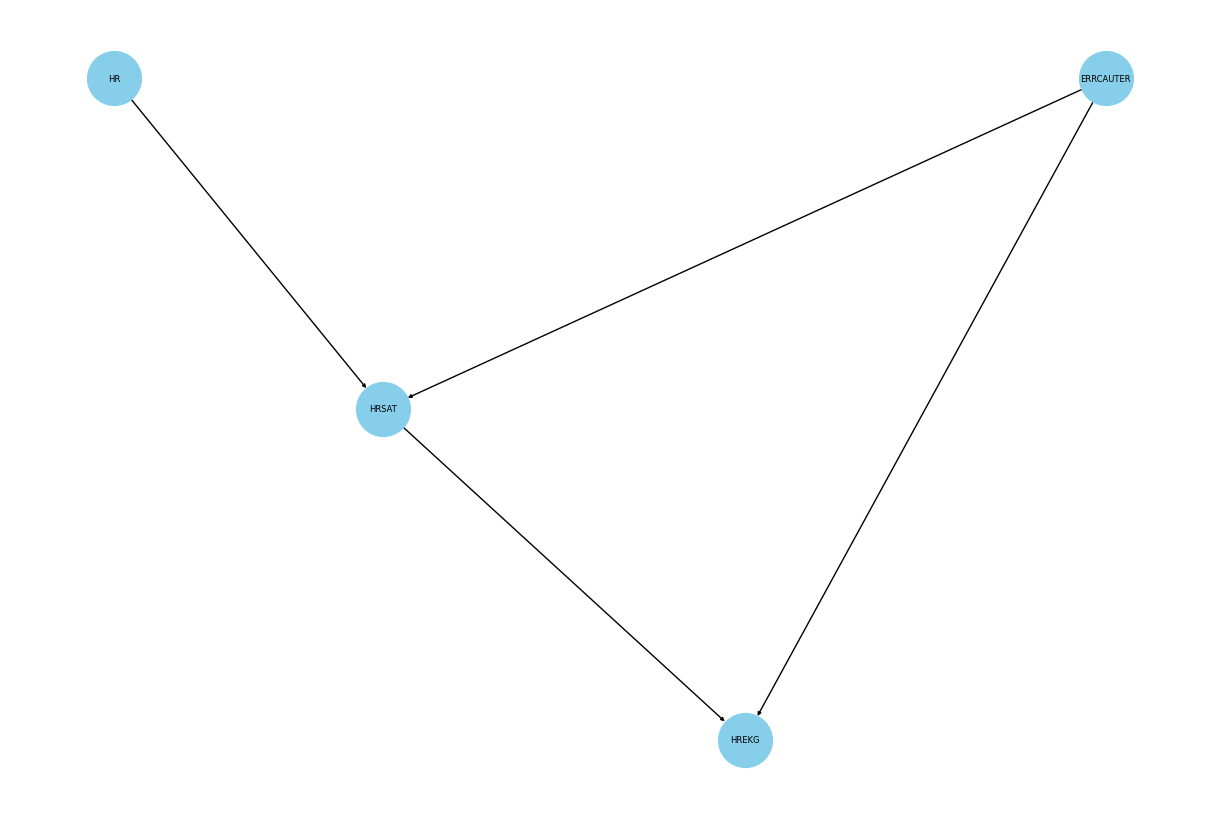

In [1020]:
metrics(markov_blanket(ground_bn, target_name), explainer.pc_dag, target_name)